In [ ]:
!pip install numpy tensorflow matplotlib scikit-learn

   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB 660.6 kB/s eta 0:09:29
   ---------------------------------------- 0.1/375.9 MB 1.1 MB/s eta 0:05:58
   ---------------------------------------- 0.2/375.9 MB 1.2 MB/s eta 0:05:06
   ---------------------------------------- 0.2/375.9 MB 1.3 MB/s eta 0:05:01
   ---------------------------------------- 0.3/375.9 MB 1.3 MB/s eta 0:04:47
   ---------------------------------------- 0.3/375.9 MB 1.2 MB/s eta 0:05:05
   ---------------------------------------- 0.4/375.9 MB 1.3 MB/s eta 0:04:47
   ---------------------------------------- 0.5/375.9 MB 1.3 MB/s eta 0:04:53
   ---------------------------------------- 0.6/375.9 MB 1.3 MB/s eta 0:04:41
   ---------------------------------------- 0.6/375.9 MB 1.3 MB/s eta 0:04:52
   ---------------------------------------- 0.7/375.9 MB 1.4 MB/s eta 0:04:34
   ---------------------------------------- 0.8/375.9 MB 1.4 MB/s eta


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
import os
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Setup directories (same as before)
import os
import shutil
import random

# Set base directory
base_dir = "D:\pe2\dataset"
os.chdir(base_dir)

# Ensure train, valid, and test directories exist
for split in ["train", "valid", "test"]:
    os.makedirs(split, exist_ok=True)

# Move classes into the 'train' directory if not already inside
class_dirs = [str(i) for i in range(0,3)]  # Assuming classes are labeled 0, 1, 2
if not os.path.exists(f"train/{class_dirs[0]}"):
    for class_dir in class_dirs:
        shutil.move(class_dir, "train")
        os.makedirs(f"valid/{class_dir}", exist_ok=True)
        os.makedirs(f"test/{class_dir}", exist_ok=True)

    # Split data
    for class_dir in class_dirs:
        images = os.listdir(f"train/{class_dir}")
        total_images = len(images)

        val_size = int(0.1 * total_images)
        test_size = int(0.1 * total_images)

        valid_sample = random.sample(images, val_size)
        for img in valid_sample:
            shutil.move(f"train/{class_dir}/{img}", f"valid/{class_dir}")

        remaining_images = os.listdir(f"train/{class_dir}")
        test_sample = random.sample(remaining_images, test_size)
        for img in test_sample:
            shutil.move(f"train/{class_dir}/{img}", f"test/{class_dir}")

print("Dataset successfully split into train, validation, and test sets.")


Dataset successfully split into train, validation, and test sets.


In [3]:
# Path to datasets
train_path = "D:\pe2\dataset/train"
test_path = "D:\pe2\dataset/test"
valid_path = "D:\pe2\dataset/valid"

In [4]:
# Use ImageDataGenerator for data augmentation and preprocessing
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=4, class_mode='categorical')
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=4, class_mode='categorical')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=4, class_mode='categorical', shuffle=False)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [5]:
# Load VGG16 model with pretrained ImageNet weights
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
# Build the model
model = Sequential()
model.add(vgg)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 10 classes for digits 0-9

In [7]:
# Set VGG layers as non-trainable
for layer in vgg.layers:
    layer.trainable = False

y = train_batches.class_indices
print(y)

{'0': 0, '1': 1, '2': 2}


In [8]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])



from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

filepath = 'D:\pe2\dataset{epoch:04d}.h5'

# Set up the ModelCheckpoint
mc = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss', 
                     save_best_only=True, 
                     mode='min', 
                     verbose=2)

# You can also add EarlyStopping for better control over the training
es = EarlyStopping(monitor='val_loss', 
                   patience=5, 
                   mode='min', 
                   verbose=2)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=2)

cb = [mc,es] 

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Train the model
his = model.fit(x=train_batches, validation_data=valid_batches, epochs=5)

Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 943s 314ms/step - accuracy: 0.8553 - loss: 1.2949 - val_accuracy: 0.9253 - val_loss: 0.6018
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 987s 329ms/step - accuracy: 0.9626 - loss: 0.2707 - val_accuracy: 0.9527 - val_loss: 0.5737
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 975s 325ms/step - accuracy: 0.9824 - loss: 0.1252 - val_accuracy: 0.9387 - val_loss: 0.9501
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1032s 344ms/step - accuracy: 0.9823 - loss: 0.1355 - val_accuracy: 0.9493 - val_loss: 0.6662
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 976s 325ms/step - accuracy: 0.9858 - loss: 0.1102 - val_accuracy: 0.9560 - val_loss: 0.4895


In [ ]:
model.save("final_brain_tumor_model_main.h5")
print("Model training complete! ✅")



from tensorflow.keras import saving
keras.saving.save_model(model, 'my_model.keras')

Model training complete! ✅


# 1. Data Pipeline Visualization
A flowchart showing how MRI images are processed:

Raw MRI Image → Preprocessing → Augmentation → Model Prediction
You can use matplotlib to show sample images at each stage.

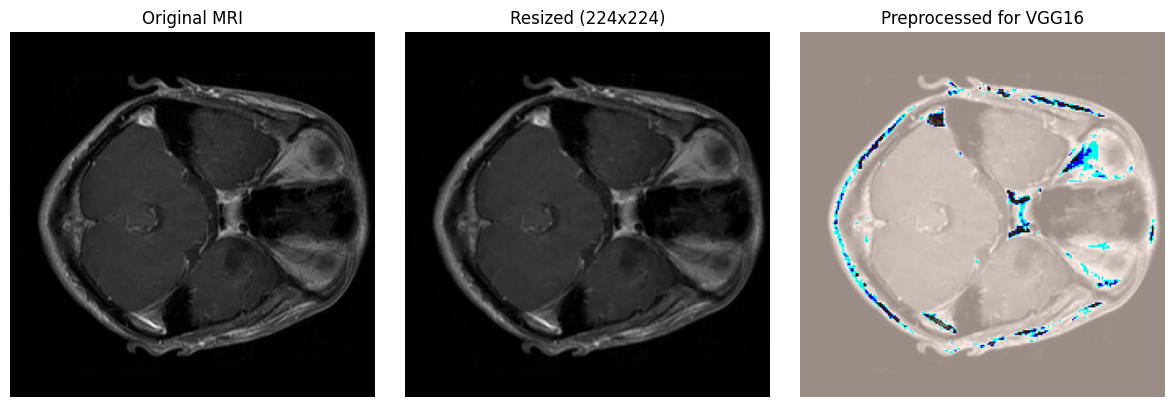

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image

# Load a sample image
img_path = "D:/pe2/dataset/valid/0/brain_glioma_0053.jpg"  # Change to an actual MRI image path
img = Image.open(img_path)
img_resized = img.resize((224, 224))

# Convert to array and preprocess
img_array = np.array(img_resized)
img_preprocessed = preprocess_input(img_array)

# Plot the transformation
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img)  # Original Image
axes[0].set_title("Original MRI")
axes[0].axis("off")

axes[1].imshow(img_resized)  # Resized Image
axes[1].set_title("Resized (224x224)")
axes[1].axis("off")

axes[2].imshow(img_preprocessed.astype("uint8"))  # Preprocessed Image
axes[2].set_title("Preprocessed for VGG16")
axes[2].axis("off")

plt.tight_layout()
plt.show()


# 2. Data Distribution (Class Balance)
Since you have three tumor types, you need a bar chart showing how many images per class exist in the dataset.

In [ ]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl (11.6 MB)
   ---------------------------------------- 0.0/509.2 kB ? eta -:--:--
   -------- ------------------------------- 112.6/509.2 kB 3.3 MB/s eta 0:00:01
   -------------------------------------- - 491.5/509.2 kB 6.2 MB/s eta 0:00:01
   ---------------------------------------- 509.2/509.2 kB 5.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/347.8 kB ? eta -:--:--
   --------------------------------------- 347.8/347.8 kB 22.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\suyas\AppData\Local\Temp\ipykernel_13372\1965650647.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Tumor Type", y="Count", data=df, palette="viridis")


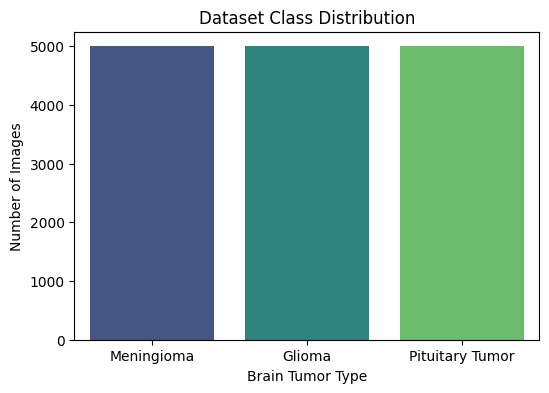

In [ ]:
import seaborn as sns
import pandas as pd

# Simulated class distribution (replace with actual counts)
class_counts = {"Meningioma": 5000, "Glioma": 5000, "Pituitary Tumor": 5000}
df = pd.DataFrame(list(class_counts.items()), columns=["Tumor Type", "Count"])

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x="Tumor Type", y="Count", data=df, palette="viridis")
plt.title("Dataset Class Distribution")
plt.xlabel("Brain Tumor Type")
plt.ylabel("Number of Images")
plt.show()


# 3. Training vs. Validation Accuracy & Loss
You need two line plots:

1. Accuracy over epochs
2. Loss over epochs

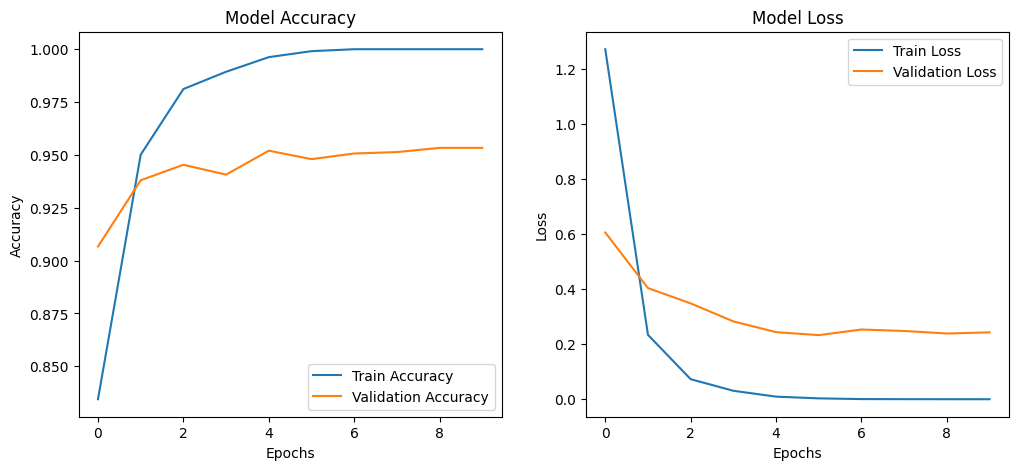

In [ ]:
plt.figure(figsize=(12, 5))

# Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(his.history["accuracy"], label="Train Accuracy")
plt.plot(his.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(his.history["loss"], label="Train Loss")
plt.plot(his.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# 4. Confusion Matrix for Model Evaluation
A confusion matrix helps analyze misclassifications and model performance per class.

c:\Users\suyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step


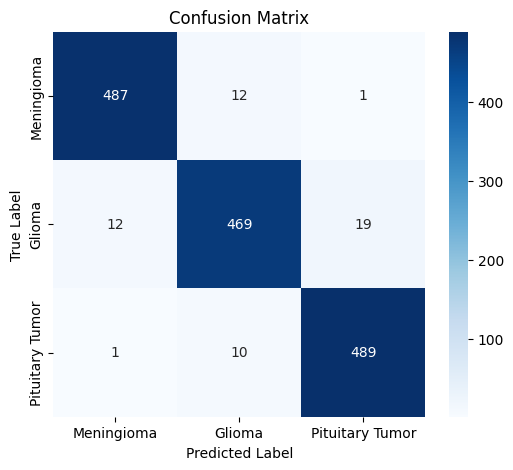

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels & predictions (assuming test_batches is used)
y_true = test_batches.classes
y_pred = np.argmax(model.predict(test_batches), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_labels = {0: "Meningioma", 1: "Glioma", 2: "Pituitary Tumor"}
# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# 5. ROC Curve for Model Performance
ROC (Receiver Operating Characteristic) curve shows how well your model distinguishes tumors.

47/47 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step


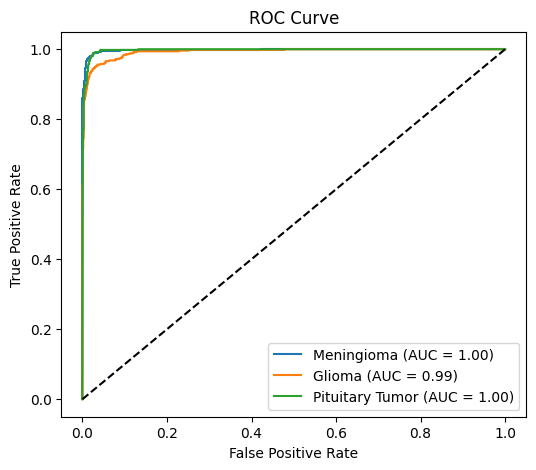

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2])  # 3 classes
y_pred_proba = model.predict(test_batches)

plt.figure(figsize=(6, 5))
for i, label in enumerate(class_labels.values()):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal Line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Precision, Recall, and F1 Score

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels.values())
print(report)


                 precision    recall  f1-score   support

     Meningioma       0.97      0.97      0.97       500
         Glioma       0.96      0.94      0.95       500
Pituitary Tumor       0.96      0.98      0.97       500

       accuracy                           0.96      1500
      macro avg       0.96      0.96      0.96      1500
   weighted avg       0.96      0.96      0.96      1500

